In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import re
import time
import string
import json
import math
from collections import defaultdict
from collections import Counter
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
word_net_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load Data
train_data_path = "data/train.csv"
test_data_path = "data/test.csv"

train_set = pd.read_csv(train_data_path)

In [4]:
train_set.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
train_set.shape

(159571, 8)

In [8]:
clean_columns = train_set.iloc[:,2:].sum(axis=1)
clean_columns = clean_columns.apply(lambda x: 0 if x > 0 else 1)
train_set['clean'] = clean_columns
train_set.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [9]:
class_occurences = train_set.iloc[:,2:].sum()
labels = class_occurences.index.values
values = class_occurences.values

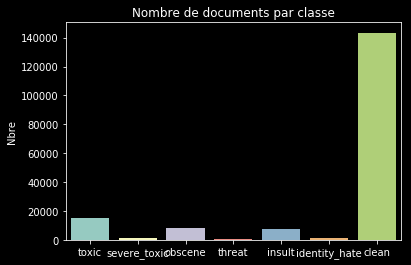

In [10]:
sns.barplot([0, 1, 2, 3, 4, 5, 6], values)
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels)
plt.ylabel("Nbre")
plt.title("Nombre de documents par classe")
plt.show()

## Clean le corpus par des méthodes très basiques

In [11]:
# Create translator to remove punctuation and digits
remove_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)

In [12]:
class corpusCleaner:
        
    def clean_corpus(self, text):
        """ This function aims at cleaning the corpus 
        Input : text
        Output : cleaned_text
        map to a list of cleaned string
        la cour d'appel \n est au meutre -->  ['appel', 'cour', 'meurtre']
        Operations done : 
        - Remove \n in tag_set
        - Remove punctuation
        - Remove numbers
        - Remove one/two lenght caracters
        - Remove stop words
        - Lemmatize words
        """
        clean_text = text.replace('\n', ' ')
        # Remove punctuation
        clean_text = clean_text.translate(remove_punctuation)
        
        # Remove digits
        clean_text = clean_text.translate(remove_digits)
        
        # To lowercase
        clean_text = clean_text.lower()
        
        split_text = clean_text.split()
        
        treated_text = []
        for word in split_text:
            lemmatized_word = word_net_lemmatizer.lemmatize(word)
            if not lemmatized_word in stop_words and len(lemmatized_word) >= 3:
                treated_text.append(lemmatized_word)
        
        return " ".join(treated_text)    

In [13]:
corpus_cleaner = corpusCleaner()
train_comments = train_set.iloc[:,1]
train_comments = train_comments.apply(lambda x: corpus_cleaner.clean_corpus(x))

In [14]:
test_comments = test_set.iloc[:, 1]
test_comments = test_comments.apply(lambda x: corpus_cleaner.clean_corpus(x))

In [15]:
train_comments.head(10)

0    explanation edits made username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really trying edit war guy constantly ...
3    make real suggestion improvement wondered sect...
4                        sir hero chance remember page
5               congratulation well use tool well talk
6                          cocksucker piss around work
7    vandalism matt shirvington article reverted pl...
8    sorry word nonsense offensive anyway intending...
9                 alignment subject contrary dulithgow
Name: comment_text, dtype: object

In [16]:
test_comments.head(10)

0    bitch rule succesful ever whats hating sad mof...
1                                   rfc title fine imo
2                           source zawe ashton lapland
3    look back source information updated correct f...
4                             anonymously edit article
5    thank understanding think highly would revert ...
6    please add nonsense wikipedia edits considered...
7                               dear god site horrible
8    fool believe number correct number lie ponder ...
9    double redirects fixing double redirects blank...
Name: comment_text, dtype: object

In [17]:
train_comments.shape

(159571,)

In [18]:
tfv = TfidfVectorizer(min_df=3, max_df=0.9, max_features=None, strip_accents='unicode',\
               analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), use_idf=1,\
               smooth_idf=1, sublinear_tf=1, stop_words='english')

In [19]:
tfv.fit(train_comments)
X_train = tfv.transform(train_comments)
X_test = tfv.transform(test_comments)

In [20]:
Y_train = train_set[train_set.columns[2:]].drop('clean', axis=1).values

In [21]:
Y_train.shape

(159571, 6)

In [22]:
random_forest = RandomForestClassifier(n_estimators=20)
random_forest.fit(X_train, Y_train)
print(random_forest.score(X_train, Y_train))

0.994015203264


In [23]:
X_test_sample = tfv.transform(['fuck asshole biatch', 'love hello'])

In [25]:
random_forest.predict(X_test_sample)

array([[ 1.,  0.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [26]:
Y_test = random_forest.predict(X_test)

In [37]:
new_submissions = pd.DataFrame(Y_test)

In [38]:
new_submissions = new_submissions.rename(columns={0: "toxic", 1: "severe_toxic", 2: 'obscene', 3: "threat", 4: 'insult', 5: "identity_hate"})


In [39]:
new_submissions.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
submissions = pd.read_csv("data/sample_submission.csv")


In [41]:
submissions.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [42]:
new_submissions.insert(0, 'id', submissions['id'])

In [43]:
new_submissions.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.0,0.0,1.0,0.0,1.0,0.0
1,0000247867823ef7,0.0,0.0,0.0,0.0,0.0,0.0
2,00013b17ad220c46,0.0,0.0,0.0,0.0,0.0,0.0
3,00017563c3f7919a,0.0,0.0,0.0,0.0,0.0,0.0
4,00017695ad8997eb,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
new_submissions.to_csv('out.csv', index = False)